In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("LANGSMITH_API_KEY")

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "scan_agent"

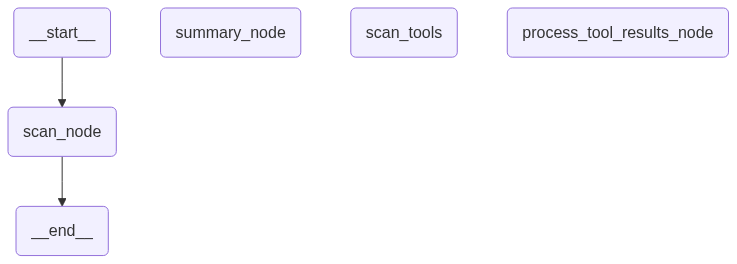

In [2]:
from IPython.display import Image, display

from scan_agent.graph import create_scan_graph

graph = create_scan_graph()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [3]:
import uuid
from datetime import timedelta

from langchain_core.runnables.config import RunnableConfig

from agent_core.graph import run_graph
from agent_core.state import ReActUsage, Target, Tools, ToolsUsage
from agent_core.tool import CURL_TOOL, FFUF_TOOL
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

state = {
    "target": Target(
        url="http://localhost:8000", description="Local REST API target", type="web"
    ),
    "usage": ReActUsage(limit=25),
    "tools_usage": ToolsUsage(
        limits={
            FFUF_TOOL.name: 2,
            CURL_TOOL.name: 5,
        }
    ),
    "tools": Tools(tools=[FFUF_TOOL, CURL_TOOL]),
}
thread_id = str(uuid.uuid4())[:8]
config = RunnableConfig(
    max_concurrency=10,
    recursion_limit=25,
    configurable={"thread_id": thread_id},
)

print(f"🚀 Starting improved event processing with thread ID: {thread_id}")
print("=" * 80)

event = await run_graph(graph, state, config)

🚀 Starting improved event processing with thread ID: cf73e937


2025-06-21 19:04:48,059 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-21 19:04:48,071 - INFO - Routing to tools node: scan_tools
2025-06-21 19:04:48,072 - INFO - Event received: {'scan_node': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hNEU99V3734lDnac3uxbCmFy', 'function': {'arguments': '{"target": "http://localhost:8000", "wordlist_type": "common", "extensions": "php,html,js,txt"}', 'name': 'ffuf_directory_scan'}, 'type': 'function'}, {'id': 'call_mwHZLwpS6lWkMFMLWDNtYl5b', 'function': {'arguments': '{"curl_args": "-X GET http://localhost:8000/ -I"}', 'name': 'curl_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 1643, 'total_tokens': 1723, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0,

In [4]:
event

{'summary_node': {'summary': ScanAgentSummary(discovered_endpoints=[DiscoveredEndpoint(path='/docs', status_code=200, content_type='text/html', notes='Swagger UI; reveals API structure and endpoints.'), DiscoveredEndpoint(path='/openapi.json', status_code=200, content_type='application/json', notes='Full OpenAPI specification; exposes all API endpoints and models.'), DiscoveredEndpoint(path='/health', status_code=200, content_type='application/json', notes='Health check endpoint.'), DiscoveredEndpoint(path='/users', status_code=200, content_type='application/json', notes='User listing; no authentication required.'), DiscoveredEndpoint(path='/login', status_code=200, content_type='application/json', notes='Login endpoint; weak authentication.'), DiscoveredEndpoint(path='/search', status_code=200, content_type='application/json', notes='Search endpoint; vulnerable to SQL injection.'), DiscoveredEndpoint(path='/admin/system', status_code=200, content_type='application/json', notes='Comman

In [5]:
from IPython.display import Markdown

states = list(graph.get_state_history(config))

Markdown(states[0].values['summary'].to_markdown())

# 🔍 Reconnaissance Summary Report

---

## 📋 Executive Summary

Reconnaissance identified a FastAPI application running on uvicorn with Python 3.9.0, exposing a wide range of endpoints. Critical vulnerabilities include exposed credentials and secrets at /admin/debug, command injection at /admin/system, SQL injection at /search, path traversal at /files/{file_path}, unrestricted file upload at /upload, and IDOR at /user/{user_id}. The most immediate risks are credential abuse, remote code execution, and sensitive data exposure. Attackers should prioritize credential use, command injection, file upload exploitation, and path traversal in the next phase.

## 💻 Technology Stack

### 🟢 uvicorn

**Confidence:** High

**Evidence:** Server header and error messages.

### 🟢 FastAPI 0.104.1

**Confidence:** High

**Evidence:** Swagger UI, OpenAPI spec, and error messages.

### 🟢 Python 3.9.0

**Confidence:** High

**Evidence:** Error messages and debug info.

## 🔍 Discovered Endpoints

| Path | Status | Content Type | Notes |
|------|--------|--------------|-------|
| `/docs` | 200 | text/html | Swagger UI; reveals API structure and endpoints. |
| `/openapi.json` | 200 | application/json | Full OpenAPI specification; exposes all API endpoints and models. |
| `/health` | 200 | application/json | Health check endpoint. |
| `/users` | 200 | application/json | User listing; no authentication required. |
| `/login` | 200 | application/json | Login endpoint; weak authentication. |
| `/search` | 200 | application/json | Search endpoint; vulnerable to SQL injection. |
| `/admin/system` | 200 | application/json | Command injection simulation. |
| `/files/{file_path}` | 200 | application/octet-stream | Path traversal possible. |
| `/user/{user_id}` | 200 | application/json | No authorization check; IDOR possible. |
| `/user` | 200 | application/json | User creation; no input validation. |
| `/admin/debug` | 200 | application/json | Sensitive info exposure; credentials, API keys, internal endpoints. |
| `/upload` | 200 | application/json | File upload; no validation. |
| `/admin/backup` | 200 | application/json | Internal endpoint (from debug info); could expose backups. |
| `/admin/logs` | 200 | application/json | Internal endpoint (from debug info); could expose logs. |
| `/internal/metrics` | 200 | application/json | Internal endpoint (from debug info); could expose metrics. |

## 🔓 Sensitive Information

### 🔴 Credentials

**Location:** `/admin/debug`

**Risk Level:** High

**Details:** admin/admin123, user/password, test/test; roles and API keys also exposed.

### 🔴 Secret Keys

**Location:** `/admin/debug`

**Risk Level:** High

**Details:** super-secret-key-123, jwt-secret-456, database-password-789

### 🟡 Internal Endpoints

**Location:** `/admin/debug`

**Risk Level:** Medium

**Details:** /admin/backup, /admin/logs, /internal/metrics

## 🚨 Vulnerabilities

### 🔴 CRITICAL Severity (1)

#### Sensitive Information Exposure

**Location:** `/admin/debug`

**Description:** Exposes credentials, API keys, and internal endpoints.

**Impact:** Immediate compromise of accounts and secrets.

### 🟠 HIGH Severity (4)

#### Command Injection

**Location:** `/admin/system`

**Description:** Allows arbitrary command execution.

**Impact:** Remote code execution.

#### SQL Injection

**Location:** `/search`

**Description:** SQL injection possible via query parameter.

**Impact:** Database compromise.

#### Path Traversal

**Location:** `/files/{file_path}`

**Description:** Allows reading arbitrary files from the server.

**Impact:** Sensitive file exposure.

#### Unrestricted File Upload

**Location:** `/upload`

**Description:** No validation on uploaded files.

**Impact:** Potential for remote code execution.

### 🟡 MEDIUM Severity (1)

#### Insecure Direct Object Reference (IDOR)

**Location:** `/user/{user_id}`

**Description:** No authorization check on user data access.

**Impact:** User data exposure.

## ⚠️ Risk Assessment

### 🔴 Sensitive Data Exposure

**Priority:** High

**Details:** Credentials and secrets are exposed via /admin/debug.

**Rationale:** Immediate risk of account and system compromise.

### 🔴 Remote Code Execution

**Priority:** High

**Details:** Command injection and file upload vulnerabilities.

**Rationale:** Potential for full system takeover.

### 🔴 Sensitive File Exposure

**Priority:** High

**Details:** Path traversal vulnerability.

**Rationale:** Access to sensitive files may lead to further compromise.

### 🔴 Database Compromise

**Priority:** High

**Details:** SQL injection via /search.

**Rationale:** Can lead to data theft or manipulation.

### 🟡 User Data Exposure

**Priority:** Medium

**Details:** IDOR on /user/{user_id}.

**Rationale:** User privacy violation.

## ⚔️ Attack Recommendations

### 🔴 1. Credential Stuffing

**Target:** `/login`

**Priority:** High

**Description:** Use exposed credentials from /admin/debug to authenticate.

**Prerequisites:** None; credentials are known.


### 🟠 2. Command Injection

**Target:** `/admin/system`

**Priority:** High

**Description:** Attempt to execute arbitrary commands via the cmd parameter.

**Prerequisites:** Access to /admin/system endpoint.


### 🟡 3. File Upload Exploitation

**Target:** `/upload`

**Priority:** High

**Description:** Upload a web shell or malicious file due to lack of validation.

**Prerequisites:** Access to /upload endpoint.


### 🟢 4. Path Traversal

**Target:** `/files/{file_path}`

**Priority:** High

**Description:** Attempt to read sensitive files using directory traversal sequences.

**Prerequisites:** Access to /files endpoint.


### 🔵 5. SQL Injection

**Target:** `/search`

**Priority:** High

**Description:** Exploit SQL injection via the q parameter.

**Prerequisites:** Access to /search endpoint.


### ⚪ 6. IDOR

**Target:** `/user/{user_id}`

**Priority:** Medium

**Description:** Access other users' data by enumerating user IDs.

**Prerequisites:** Access to /user/{user_id} endpoint.


---

*Report generated by Scan Agent* 🤖


In [6]:
states[0].values['summary'].to_markdown()

"# 🔍 Reconnaissance Summary Report\n\n---\n\n## 📋 Executive Summary\n\nReconnaissance identified a FastAPI application running on uvicorn with Python 3.9.0, exposing a wide range of endpoints. Critical vulnerabilities include exposed credentials and secrets at /admin/debug, command injection at /admin/system, SQL injection at /search, path traversal at /files/{file_path}, unrestricted file upload at /upload, and IDOR at /user/{user_id}. The most immediate risks are credential abuse, remote code execution, and sensitive data exposure. Attackers should prioritize credential use, command injection, file upload exploitation, and path traversal in the next phase.\n\n## 💻 Technology Stack\n\n### 🟢 uvicorn\n\n**Confidence:** High\n\n**Evidence:** Server header and error messages.\n\n### 🟢 FastAPI 0.104.1\n\n**Confidence:** High\n\n**Evidence:** Swagger UI, OpenAPI spec, and error messages.\n\n### 🟢 Python 3.9.0\n\n**Confidence:** High\n\n**Evidence:** Error messages and debug info.\n\n## 🔍 Di

In [7]:
states[0].values['summary'].model_dump_json()

'{"discovered_endpoints":[{"path":"/docs","status_code":200,"content_type":"text/html","notes":"Swagger UI; reveals API structure and endpoints."},{"path":"/openapi.json","status_code":200,"content_type":"application/json","notes":"Full OpenAPI specification; exposes all API endpoints and models."},{"path":"/health","status_code":200,"content_type":"application/json","notes":"Health check endpoint."},{"path":"/users","status_code":200,"content_type":"application/json","notes":"User listing; no authentication required."},{"path":"/login","status_code":200,"content_type":"application/json","notes":"Login endpoint; weak authentication."},{"path":"/search","status_code":200,"content_type":"application/json","notes":"Search endpoint; vulnerable to SQL injection."},{"path":"/admin/system","status_code":200,"content_type":"application/json","notes":"Command injection simulation."},{"path":"/files/{file_path}","status_code":200,"content_type":"application/octet-stream","notes":"Path traversal 